In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import copy

# %matplotlib notebook
%matplotlib inline

In [2]:
class Data:
    def __init__(self, params):
        self.a = params['a']
        self.b = params['b']
        self.c = params['c']
        self.d = params['d']
        self.lx = params['lx']
        self.ly = params['ly']
        self.f = params['f']
        self.alpha1 = params['alpha1']
        self.alpha2 = params['alpha2']
        self.beta1 = params['beta1']
        self.beta2 = params['beta2']
        self.gamma1 = params['gamma1']
        self.gamma2 = params['gamma2']
        self.delta1 = params['delta1']
        self.delta2 = params['delta2']
        self.phi11 = params['phi11']
        self.phi21 = params['phi21']
        self.phi12 = params['phi12']
        self.phi22 = params['phi22']
        self.psi = params['psi']
        self.solution = params['solution']

In [15]:
def diff(L, u, nx, ny):
    mx = 0
    for i in range(nx):
        for j in range(ny):
            mx = max(mx, abs(u[i][j] - L[i][j]))
    return mx

def compareError(a, b):
    err = 0
    lst = [abs(i - j) for i, j in zip(a, b)]
    for each in lst:
        err = max(err, each)
    return err

In [59]:
class ParabolicSolver:
    def __init__(self, params, nx, ny, T, K):
        self.data = Data(params)
        self.hx = self.data.lx / nx
        self.hy = self.data.ly / ny
        self.tau = T / K

        self.nx = nx
        self.ny = ny
        self.T = T
        self.K = K

        x, y, t = self.prepare(nx, ny, T, K)

        uu = self.initalizeU(x, y, t)
        
        self.x = x
        self.y = y
        self.t = t
        self.uu = uu

    def getCoeffs(self, n):
        aa = np.zeros(len(n))
        bb = np.zeros(len(n))
        cc = np.zeros(len(n))
        dd = np.zeros(len(n))

        return aa, bb, cc, dd

    def computeCoeffs(self, x, y, t2, j):
        aa, bb, cc, dd = self.getCoeffs(x)
        bb[0] = self.hx * self.data.alpha2 - self.data.alpha1
        bb[-1] = self.hx * self.data.beta2 + self.data.beta1
        cc[0] = self.data.alpha1
        aa[-1] = -self.data.beta1
        dd[0] = self.data.phi11(y[j], t2) * self.hx
        dd[-1] = self.data.phi12(y[j], t2) * self.hx

        return aa, bb, cc, dd

    def prepare(self, nx, ny, T, K):
        self.hx = self.data.lx / nx
        self.hy = self.data.ly / ny
        self.tau = T / K
        x = np.arange(0, self.data.lx + self.hx, self.hx)
        y = np.arange(0, self.data.ly + self.hy, self.hy)
        t = np.arange(0, T + self.tau, self.tau)

        return x, y, t

    def initalizeU(self, x, y, t):
        u = np.zeros((len(x), len(y), len(t)))
        for i in range(len(x)):
            for j in range(len(y)):
                u[i][j][0] = self.data.psi(x[i], y[j])

        return u


    def analyticSolve(self):
        nx, ny, T, K = self.nx, self.ny, self.T, self.K
        # дает решение аналитическое
        x, y, t = self.prepare(nx, ny, T, K)

        uu = np.zeros((len(x), len(y), len(t)))

        for i in range(len(x)):
            for j in range(len(y)):
                for k in range(len(t)):
                    uu[i][j][k] = self.data.solution(x[i], y[j], t[k])

        return uu

    def parallelDirections_solver(self):
        x, y, t, uu = self.x, self.y, self.t, self.uu

        for k in range(1, len(t)):
            u1 = np.zeros((len(x), len(y)))
            t2 = t[k] - self.tau / 2
            for j in range(len(y) - 1):
                aa, bb, cc, dd = self.computeCoeffs(x, y, t2, j)
                for i in range(len(x) - 1):
                    aa[i] = self.data.a - self.hx * self.data.c / 2
                    bb[i] = self.hx ** 2 - 2 * (self.hx ** 2) / self.tau - 2 * self.data.a
                    cc[i] = self.data.a + self.hx * self.data.c / 2
                    dd[i] = -2 * (self.hx ** 2) * uu[i][j][k - 1] / self.tau
                    - self.data.b * (self.hx ** 2) * (uu[i][j + 1][k - 1]
                                                      - 2 * uu[i][j][k - 1] + uu[i][j - 1][k - 1]) / (self.hy ** 2)
                    - self.data.d * (self.hx ** 2) * (uu[i][j + 1][k - 1] - uu[i][j - 1][k - 1]) / (2 * self.hy ** 2)
                    - (self.hx ** 2) * self.data.f(x[i], y[j], t[k])

                xx = self.progonka(aa, bb, cc, dd)
                for i in range(len(x)):
                    u1[i][j] = xx[i]
                    u1[i][0] = (self.data.phi21(x[i], t2) - self.data.gamma1 * u1[i][1] / self.hy) / (
                            self.data.gamma2 - self.data.gamma1 / self.hy)
                    u1[i][-1] = (self.data.phi22(x[i], t2) + self.data.delta1 * u1[i][-2] / self.hy) / (
                            self.data.delta2 + self.data.delta1 / self.hy)
            for j in range(len(y)):
                u1[0][j] = (self.data.phi11(y[j], t2) - self.data.alpha1 * u1[1][j] / self.hx) / (
                        self.data.alpha2 - self.data.alpha1 / self.hx)
                u1[-1][j] = (self.data.phi12(y[j], t2) + self.data.beta1 * u1[-2][j] / self.hx) / (
                        self.data.beta2 + self.data.beta1 / self.hx)
            ####
            u2 = np.zeros((len(x), len(y)))
            for i in range(len(x) - 1):
                aa, bb, cc, dd = self.getCoeffs(y)
                bb[0] = self.hy * self.data.gamma2 - self.data.gamma1
                bb[-1] = self.hy * self.data.delta2 + self.data.delta1
                cc[0] = self.data.gamma1
                aa[-1] = -self.data.delta1
                dd[0] = self.data.phi21(x[i], t[k]) * self.hy
                dd[-1] = self.data.phi22(x[i], t[k]) * self.hy

                for j in range(len(y) - 1):
                    aa[j] = self.data.b - self.hy * self.data.d / 2
                    bb[j] = self.hy ** 2 - 2 * (self.hy ** 2) / self.tau - 2 * self.data.b
                    cc[j] = self.data.b + self.hy * self.data.d / 2
                    dd[j] = -2 * (self.hy ** 2) * u1[i][j] / self.tau
                    - self.data.a * (self.hy ** 2) * (u1[i + 1][j]
                                                      - 2 * u1[i][j] + u1[i - 1][j]) / (self.hx ** 2)
                    - self.data.c * (self.hy ** 2) * (u1[i + 1][j] - u1[i - 1][j]) / (2 * self.hx ** 2)
                    - (self.hy ** 2) * self.data.f(x[i], y[j], t[k])
                xx = self.progonka(aa, bb, cc, dd)
                for j in range(len(y)):
                    u2[i][j] = xx[j]
                    u2[0][j] = (self.data.phi11(y[j], t[k]) - self.data.alpha1 * u2[1][j] / self.hx) / (
                            self.data.alpha2 - self.data.alpha1 / self.hx)
                    u2[-1][j] = (self.data.phi12(y[j], t[k]) + self.data.beta1 * u2[-2][j] / self.hx) / (
                            self.data.beta2 + self.data.beta1 / self.hx)
            for i in range(len(x)):
                u2[i][0] = (self.data.phi21(x[i], t[k]) - self.data.gamma1 * u2[i][1] / self.hy) / (
                        self.data.gamma2 - self.data.gamma1 / self.hy)
                u2[i][-1] = (self.data.phi22(x[i], t[k]) + self.data.delta1 * u2[i][-2] / self.hy) / (
                        self.data.delta2 + self.data.delta1 / self.hy)
            for i in range(len(x)):
                for j in range(len(y)):
                    uu[i][j][k] = u2[i][j]
        return uu

    def fractionalSteps_solver(self):
        x, y, t, uu = self.x, self.y, self.t, self.uu
        
        for k in range(len(t)):
            u1 = np.zeros((len(x), len(y)))
            t2 = t[k] - self.tau / 2
            for j in range(len(y) - 1):
                aa, bb, cc, dd = self.computeCoeffs(x, y, t2, j)
                for i in range(len(x) - 1):
                    aa[i] = self.data.a
                    bb[i] = -(self.hx ** 2) / self.tau - 2 * self.data.a
                    cc[i] = self.data.a
                    dd[i] = -(self.hx ** 2) * uu[i][j][k - 1] / self.tau - (self.hx ** 2) * self.data.f(x[i], y[j],
                                                                                                        t2) / 2
                xx = self.progonka(aa, bb, cc, dd)
                for i in range(len(x)):
                    u1[i][j] = xx[i]
                    u1[i][0] = (self.data.phi21(x[i], t2) - self.data.gamma1 * u1[i][1] / self.hy) / (
                            self.data.gamma2 - self.data.gamma1 / self.hy)
                    u1[i][-1] = (self.data.phi22(x[i], t2) + self.data.delta1 * u1[i][-2] / self.hy) / (
                            self.data.delta2 + self.data.delta1 / self.hy)
            for j in range(len(y)):
                u1[0][j] = (self.data.phi11(y[j], t2) - self.data.alpha1 * u1[1][j] / self.hx) / (
                        self.data.alpha2 - self.data.alpha1 / self.hx)
                u1[-1][j] = (self.data.phi12(y[j], t2) + self.data.beta1 * u1[-2][j] / self.hx) / (
                        self.data.beta2 + self.data.beta1 / self.hx)
            #####
            u2 = np.zeros((len(x), len(y)))
            for i in range(len(x) - 1):
                aa, bb, cc, dd = self.getCoeffs(y)
                bb[0] = self.hy * self.data.gamma2 - self.data.gamma1
                bb[-1] = self.hy * self.data.delta2 + self.data.delta1
                cc[0] = self.data.gamma1
                aa[-1] = -self.data.delta1
                dd[0] = self.data.phi21(x[i], t[k]) * self.hy
                dd[-1] = self.data.phi22(x[i], t[k]) * self.hy

                for j in range(len(y) - 1):
                    aa[j] = self.data.b
                    bb[j] = -(self.hy ** 2) / self.tau - 2 * self.data.b
                    cc[j] = self.data.b
                    dd[j] = -(self.hy ** 2) * u1[i][j] / self.tau - (self.hy ** 2) * self.data.f(x[i], y[j], t[k]) / 2
                xx = self.progonka(aa, bb, cc, dd)
                for j in range(len(y)):
                    u2[i][j] = xx[j]
                    u2[0][j] = (self.data.phi11(y[j], t[k]) - self.data.alpha1 * u2[1][j] / self.hx) / (
                            self.data.alpha2 - self.data.alpha1 / self.hx)
                    u2[-1][j] = (self.data.phi12(y[j], t[k]) + self.data.beta1 * u2[-2][j] / self.hx) / (
                            self.data.beta2 + self.data.beta1 / self.hx)
            for i in range(len(x)):
                u2[i][0] = (self.data.phi21(x[i], t[k]) - self.data.gamma1 * u2[i][1] / self.hy) / (
                        self.data.gamma2 - self.data.gamma1 / self.hy)
                u2[i][-1] = (self.data.phi22(x[i], t[k]) + self.data.delta1 * u2[i][-2] / self.hy) / (
                        self.data.delta2 + self.data.delta1 / self.hy)
            for i in range(len(x)):
                for j in range(len(y)):
                    uu[i][j][k] = u2[i][j]
        return uu
    
    
    def progonka(self, a, b, c, d):
        # print('a', a, 'b', b, 'c', c, 'd', d, sep='\n')
        n = len(a)
        for i in range(1, n):
            if math.fabs(b[i]) < math.fabs(a[i]) + math.fabs(c[i]):
                raise Exception(f"{math.fabs(b[i])} < {math.fabs(a[i]) + math.fabs(c[i])}, a[{i}]={a[i]}, b[{i}]={b[i]}, c[{i}]={c[i]}")

        #   Формирование массивов P, Q (Расчет значений) ((Прямой ход))

        P, Q = [-c[0] / b[0]], [d[0] / b[0]]

        for i in range(1, n):
            P.append(-c[i] / (b[i] + a[i] * P[i - 1]))
            Q.append((d[i] - a[i] * Q[i - 1]) / (b[i] + a[i] * P[i - 1]))

        #   Вычисление решения системы (Обратный ход)
        x = [Q[n - 1]]
        for i in range(1, n):
            x.append(P[n - 1 - i] * x[i - 1] + Q[n - 1 - i])

        # print('result', np.array([i for i in reversed(x)]))

        return np.array([i for i in reversed(x)])



In [61]:
a = 1

params = {
    'a': 1,
    'b': 1,
    'c': 0,
    'd': 0,
    'lx': np.pi / 4,
    'ly': np.log(2),
    'f': lambda x, y, t: 0,
    'alpha1': 0,
    'alpha2': 1,
    'beta1': 0,
    'beta2': 1,
    'gamma1': 0,
    'gamma2': 1,
    'delta1': 0,
    'delta2': 1,
    'phi11': lambda y, t: np.cosh(2 * y) * np.exp(-3 * a * t),
    'phi12': lambda y, t: 0,
    'phi21': lambda x, t: np.cos(2 * x) * np.exp(-3 * a * t),
    'phi22': lambda x, t: np.cos(2 * x) * np.exp(-3 * a * t) * 5 / 4,
    'psi': lambda x, y: np.cos(2 * x) * np.cosh(y),
    'solution': lambda x, y, t: np.cos(2 * x) * np.cosh(y) * np.exp(-3 * a * t),
}

In [62]:
nx = 40
ny = 40
T = 5
K = 200

In [63]:
solver = ParabolicSolver(params, nx, ny, T, K)

In [64]:
U = solver.analyticSolve()
fractionalSteps = solver.fractionalSteps_solver()
parallelDirections = solver.parallelDirections_solver()

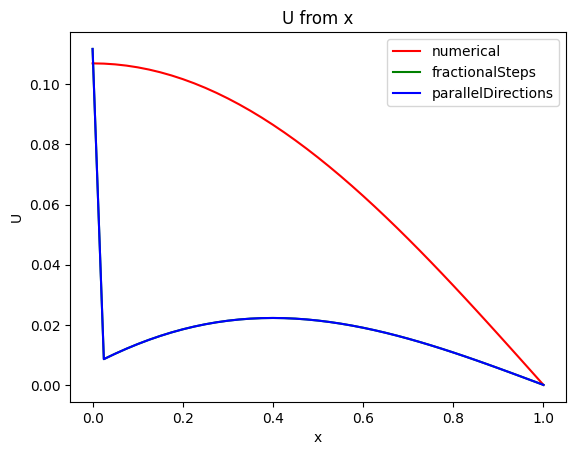

In [70]:
fig = plt.figure()
hx = 1 / nx
hy = 1 / ny
tau = T / K

x = np.arange(0, 1 + hx, hx)
y = np.arange(0, 1 + hy, hy)
t = np.arange(0, T + tau, tau)

time = 30

# z2 = approximation_an(x, 10, time, dict_)  # for i in range(len(x))
plt.title('U from x')
plt.plot(x, U[:, 10, 30], color='r', label='numerical')
plt.plot(x, fractionalSteps[:, 10, 30], color='g', label='fractionalSteps')
plt.plot(x, parallelDirections[:, 10, 30], color='b', label='parallelDirections')
plt.legend(loc='best')
plt.ylabel('U')
plt.xlabel('x')
plt.show()

err = []
plt.show()

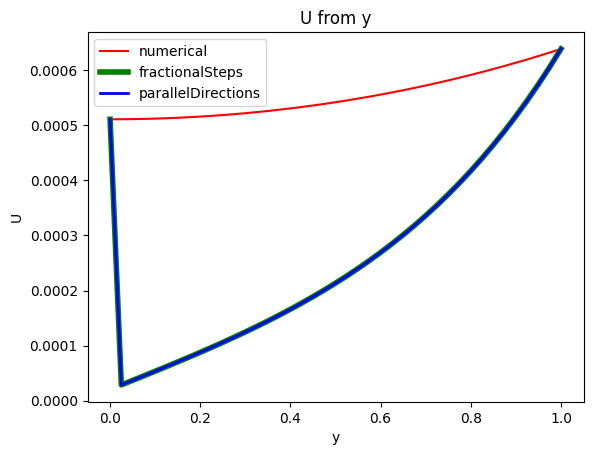

In [81]:
plt.title('U from y')
plt.plot(y, U[10, :, 100], color='r', label='numerical')
plt.plot(y, fractionalSteps[10, :, 100], color='g', label='fractionalSteps', linewidth=4)
plt.plot(y, parallelDirections[10, :, 100], color='b', label='parallelDirections', linewidth=2)
plt.legend(loc='best')
plt.ylabel('U')
plt.xlabel('y')
plt.show()


In [78]:
def sq_error(A, B):
    summa = 0
    n = 0
    for i in range(len(A)):
        for j in range(len(A[0])):
            for k in range(len(A[0][0])):
                summa += (A[i][j][k] + B[i][j][k])
                n += 1

    return math.sqrt(summa/n)


In [82]:
print('Среднеквадратичная ошибка дробных шагов', sq_error(U, fractionalSteps))

Среднеквадратичная ошибка дробных шагов 0.2645255543318964


In [83]:
print('Среднеквадратичная ошибка переменных направлений', sq_error(U, parallelDirections))

Среднеквадратичная ошибка переменных направлений 0.2645255543318964
